# Optical flow estimation

We will focus on the Luca Kanade algorithm. It is based on the derivative estimation

In [ ]:
%pip install opencv-python
# Importing the required libraries to compare our implementation (dense estimator) with the OpenCV implementation (sparse optical flow)

In [2]:
import numpy as np
import cv2 as cv2
from scipy import signal
import matplotlib.pyplot as plt
from visualize_flow import flow_to_color
import time
%matplotlib inline


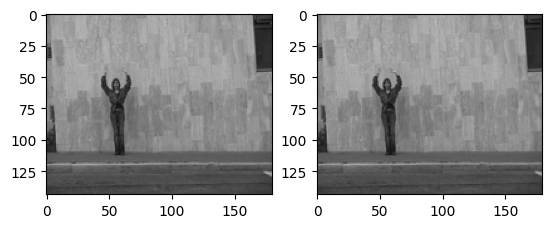

In [3]:
# LOAD AND VISUALIZE AN IMAGE PAIR

#img1= cv2.imread('Data/EmptyScene01.jpg',cv2.IMREAD_GRAYSCALE)
#img2= cv2.imread('Data/EmptyScene02.jpg',cv2.IMREAD_GRAYSCALE)
img1= cv2.imread('Data/waving/JPEGImages/daria_wave2004.png',cv2.IMREAD_GRAYSCALE)
img2= cv2.imread('Data/waving/JPEGImages/daria_wave2005.png',cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

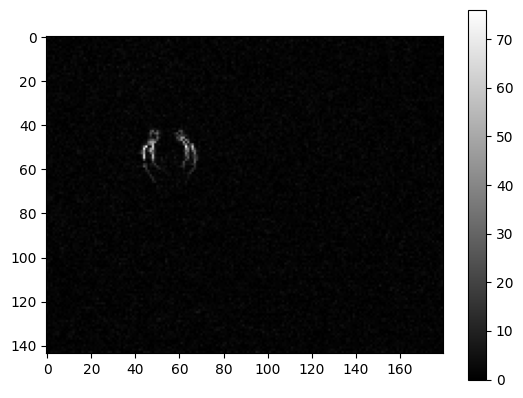

In [4]:
# Computing and visualize the absolute difference between the two images (img1-img2) using the function cv2.absdiff from OpenCV

diff = cv2.absdiff(img1, img2)
plt.figure()
plt.imshow(diff, cmap='gray')
plt.colorbar()


### Lucas Kanade: our dense implementation

In [5]:
def Lucas_Kanade(im1,im2,window_size):
    kernel_x = np.array([[-1., 1.], [-1., 1.]])*.25
    kernel_y = np.array([[-1., -1.], [1., 1.]])*.25
    kernel_t = np.array([[1., 1.], [1., 1.]])*.25
    w = int(window_size/2) # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1g = im1 / 255. # normalize pixels
    I2g = im2 / 255. # normalize pixels
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t
    mode = 'same'
    # you may want to try uncommenting the comments in the two lines below (notice any difference?)
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode) #+ signal.convolve2d(I2g, kernel_x, boundary='symm', mode=mode)  
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode=mode) #+ signal.convolve2d(I2g, kernel_y, boundary='symm', mode=mode)  
    ft = signal.convolve2d(I1g, kernel_t, boundary='symm', mode=mode) +signal.convolve2d(I2g, -kernel_t, boundary='symm', mode=mode)

    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)

    # within window window_size * window_size

    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].transpose().flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].transpose().flatten()
            It = np.array(ft[i-w:i+w+1, j-w:j+w+1].transpose().flatten())

            A = np.transpose(np.array([Ix ,Iy]))

            AT =A.transpose()

            ATA = np.matmul(AT,A)   
            It = -It

            Inv = np.linalg.pinv(ATA)
            U = np.matmul(np.matmul(Inv,AT),It)   
            u[i,j]=U[0]
            v[i,j]=U[1]

    return (u,v)

In [10]:
start = time.time()
window=3 #assuming that motion is constant inside this window (N)
# notice the larger window the slowlier the method
[u,v] = Lucas_Kanade(img1,img2,window)
print("Elapsed time is %d seconds"%(time.time()-start) )

Elapsed time is 1 seconds


(144, 180)
(144, 180)


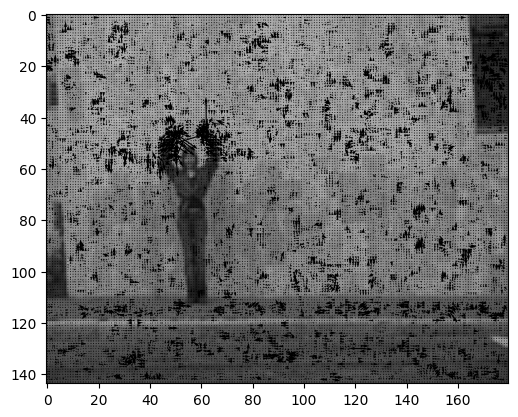

In [11]:
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
print(u.shape)
print(v.shape)
xaxis = list(np.arange(img1.shape[0]))
yaxis = list(np.arange(img1.shape[1]))
plt.quiver(u,v)

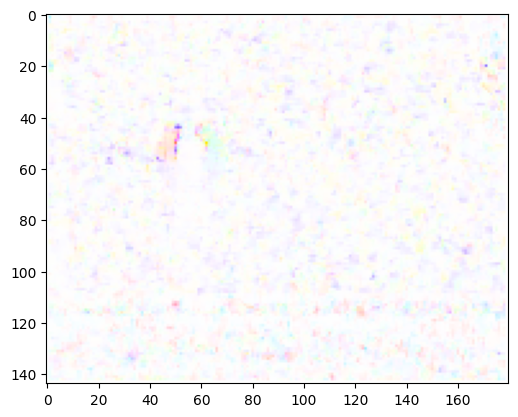

In [12]:
flow = np.stack([u,v],axis=2)
plt.imshow(flow_to_color(flow,convert_to_bgr=False))

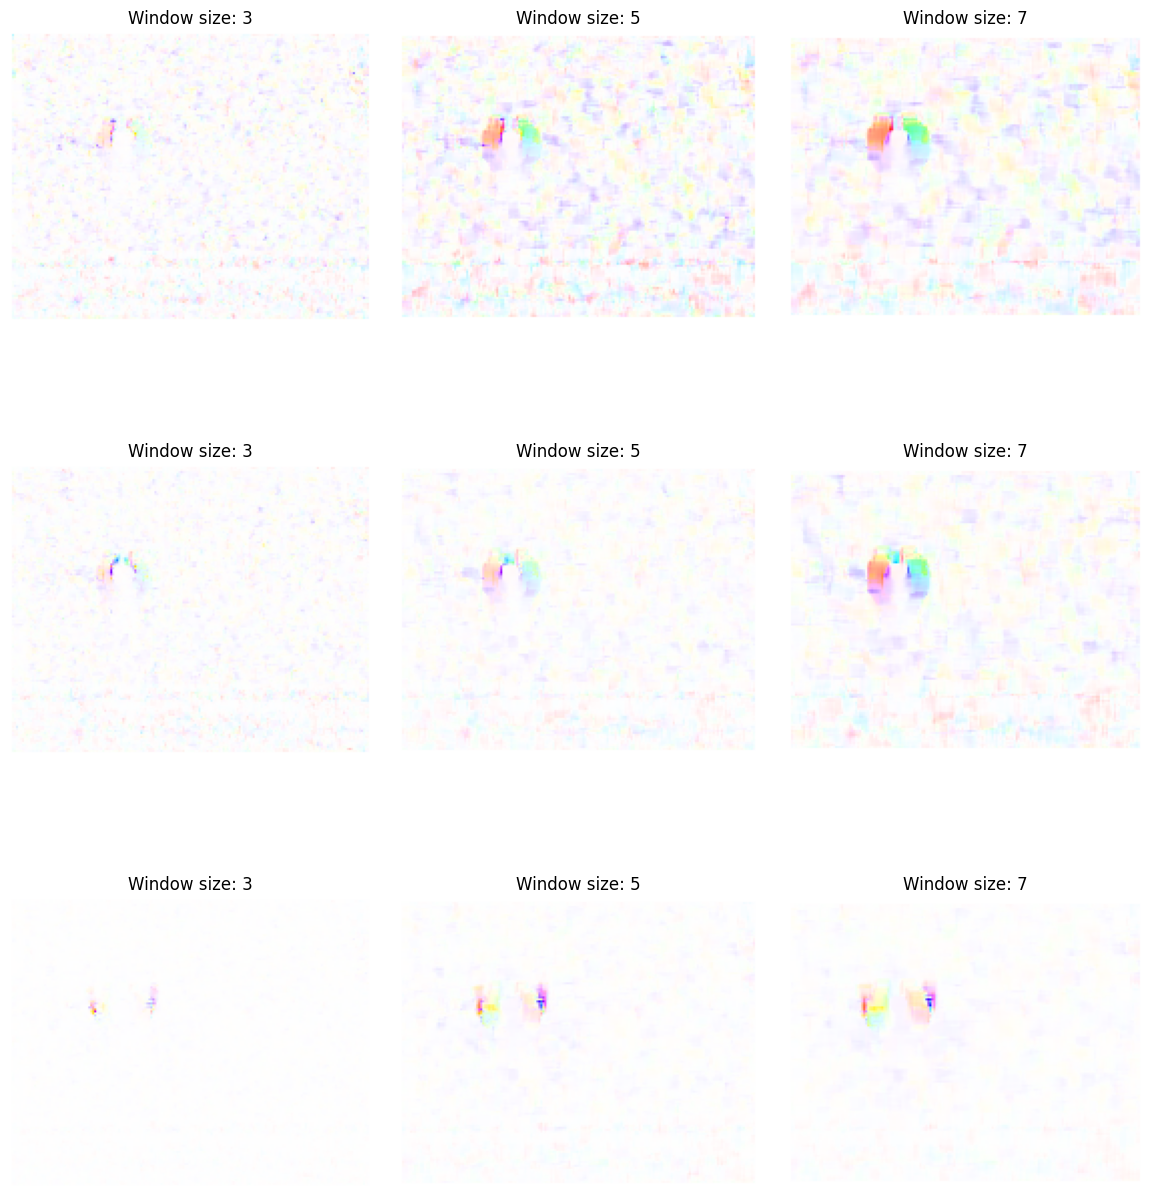

In [13]:
# In this cell i'd like to fix img1 and load two or tree different versions of img2 (the following frame) and more distant ones
# Load the optical flow i obtain for at least 3 choice of window size and visualize them.

#Load img1
img1= cv2.imread('Data/waving/JPEGImages/daria_wave2004.png',cv2.IMREAD_GRAYSCALE)

#Load img2 (the following frame with different distance)
img2= cv2.imread('Data/waving/JPEGImages/daria_wave2005.png',cv2.IMREAD_GRAYSCALE)
img3= cv2.imread('Data/waving/JPEGImages/daria_wave2007.png',cv2.IMREAD_GRAYSCALE)
img4= cv2.imread('Data/waving/JPEGImages/daria_wave2014.png',cv2.IMREAD_GRAYSCALE)

img2_list = [img2,img3,img4]

#Compute the optical flow for different window sizes
window = [3,5,7]
start = time.time()

# Crating a grid of subplots 3x3 for each window size and each couple of images
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

# Compute the optical flow for each couple of images and for each window size
for i in range(len(img2_list)):
    for j in range(len(window)):
        [u,v] = Lucas_Kanade(img1,img2_list[i],window[j])
        # Add the optical flow to the plot
        flow = np.stack([u,v],axis=2)
        axs[i*3+j].imshow(flow_to_color(flow,convert_to_bgr=False))
        axs[i*3+j].set_title("Window size: %d"%(window[j]))
        axs[i*3+j].axis('off')



### Lucas Kanade: sparse OpenCV implementation

The algorithm evaluates optical flow on sparse points (corners) in order to avoid the ill-posed inversion of A'A.

In [14]:
#parameters of the corner detection procedurea
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.1,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2, 
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

In [15]:
# Calling on img1 the function that detects the key-points (Shi-Tomasi corner detection)

p0 = cv2.goodFeaturesToTrack(img1, mask = None, **feature_params)

# Call the Lucas-Kanade optical flow function on img1 and img2

p1, st, err = cv2.calcOpticalFlowPyrLK(img1, img2, p0, None, **lk_params)

(17, 2)


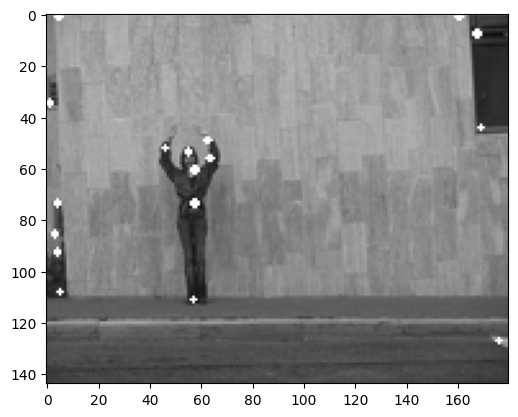

In [16]:
good_new = p1[st==1]
good_old = p0[st==1]
mask = np.zeros_like(img1)
print(good_old.shape)
for i,(new,old) in enumerate(zip(p1,p0)):
    a,b = np.int32(new.ravel())
    
    c,d = np.int32(old.ravel())
    mask = cv2.line(mask, (a,b),(c,d), [255,255,0], 2)
img2 = cv2.add(img2,mask)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))


#### Conclusion 

##### Sparse vs Dense
- with a dense estimate we obtain a full estimate of the motion, but it can be noisy (in particular in uniform areas). 
- conversely, a sparse approach focuses on reliable/stable points (not affected by the aperture problem) but it provides a lot less information

##### Size of the window
- These implementations of LK are based on local constancy of motion assumption, which may be wrong in general. From this point of view, small windows are better.
- Also, larger windows are computationally more expensive
- At the same time with larger windows we obtain a smoother estimate

In [17]:
# Now we use the algoritm (dense version) to estimate a disprity map between two images of the same scene taken from different points of view.

# Load the two images of the same scene taken from different points of view
# C:\Users\ACER\Desktop\DLCV_2024\DLCV2024_for_students\labs\LAB03_OF\LAB_OF\Data\stereo_pairs\Dino_L.png
# C:\Users\ACER\Desktop\DLCV_2024\DLCV2024_for_students\labs\LAB03_OF\LAB_OF\Data\stereo_pairs\Dino_R.png
imgL= cv2.imread('Data/stereo_pairs/Dino_L.png',cv2.IMREAD_GRAYSCALE)
imgR= cv2.imread('Data/stereo_pairs/Dino_R.png',cv2.IMREAD_GRAYSCALE)

img2L = cv2.imread('Data/stereo_pairs/Corridor_l_original.png',cv2.IMREAD_COLOR)
img2R = cv2.imread('Data/stereo_pairs/Corridor_r_original.png',cv2.IMREAD_COLOR)


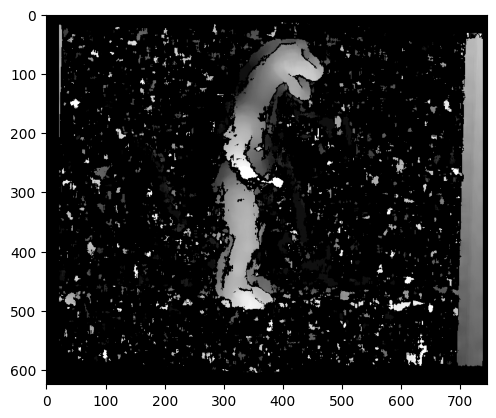

In [18]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')


In [ ]:
import cv2 # To fix

# Load your stereo images
left_image = cv2.imread('Data/stereo_pairs/Dino_L.png', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('Data/stereo_pairs/Dino_R.png', cv2.IMREAD_GRAYSCALE)

# Ensure the images are loaded correctly
if left_image is None or right_image is None:
    raise ValueError("One or both images could not be loaded.")

# Define the SADWindowSize
SADWindowSize = 21  # Example value, must be odd and within 5..255

# Ensure SADWindowSize is within the acceptable range and not larger than image dimensions
if SADWindowSize % 2 == 0 or SADWindowSize < 5 or SADWindowSize > 255:
    raise ValueError("SADWindowSize must be an odd number between 5 and 255.")
if SADWindowSize > min(left_image.shape[0], left_image.shape[1]):
    raise ValueError("SADWindowSize must not be larger than the image width or height.")

# Create the StereoBM object
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=SADWindowSize)

# Compute the disparity map
disparity = stereo.compute(left_image, right_image)

# Display the disparity map
cv2.imshow('Disparity', disparity)
cv2.waitKey(0)
cv2.destroyAllWindows()